# Jason Bhalla

## Core Code

In [1]:
# -*- coding: utf-8 -*-
"""
Incidence structure visualization (math structure independent of geometry).

Iteration engine enforces:
  1) Any two points lie on a line (by adding lines between every unconnected pair).
  2) Each added line has c points (existing pair + (c-2) new points).
     All edges on that line share the SAME generator word (no new symbols),
     chosen as the SHORTEST PATH word between that pair.

Lines are LOOPS (cycles): p0→p1→…→p(c-1)→p0, reverse edges carry the inverse word.

Mod-c normalization:
- Word algebra respects g^c = 1 for each generator g (paths, stored words, WORDS list).

Pretty math output:
- Unicode superscripts: a^{-1} b^{2} → a⁻¹b² (no spaces between factors).
- Used in plot labels, adjacency printing, WORDS printing, and per-iteration LINES listing.
"""

from dataclasses import dataclass
from typing import List, Dict, Tuple, Deque
from collections import deque
import itertools
import math
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# ========================
# Word algebra (free-group-like) with mod-c normalization
# ========================

class Word:
    """
    A reduced word over generators.
    Internally stored as a list of (symbol: str, exp: int) segments.
    Reduction merges adjacent equal symbols; mod-c normalization further reduces powers.
    """
    __slots__ = ("segs",)

    def __init__(self, segs: List[Tuple[str, int]] = None):
        self.segs: List[Tuple[str, int]] = []
        if segs:
            for sym, k in segs:
                self._append(sym, k)
        self._reduce_in_place()

    # ---- constructors ----
    @staticmethod
    def identity():
        return Word([])

    @staticmethod
    def from_gen(symbol: str, exp: int = 1):
        return Word([(symbol, exp)])

    @staticmethod
    def parse(s: str):
        """
        Parse tokens like:
           "a", "a^{-1}", "a^{2}", "a b^{-1} c^{3}"
        Splits on spaces to allow composite words.
        """
        s = s.strip()
        if s == "" or s == "0" or s == "1":
            return Word.identity()
        tokens = s.split()
        segs: List[Tuple[str, int]] = []
        for tok in tokens:
            tok = tok.strip()
            if tok in ("", "0", "1"):
                continue
            if "^" not in tok:
                segs.append((tok, 1))
            else:
                sym, exp_part = tok.split("^", 1)
                exp_part = exp_part.strip()
                if exp_part.startswith("{") and exp_part.endswith("}"):
                    exp_part = exp_part[1:-1]
                exp = int(exp_part)
                segs.append((sym, exp))
        return Word(segs)

    # ---- operations ----
    def mul_plain(self, other: "Word") -> "Word":
        """Concatenate and reduce adjacent equal symbols (no mod-c)."""
        out = Word(self.segs.copy())
        for sym, k in other.segs:
            out._append(sym, k)
        out._reduce_in_place()
        return out

    def inv(self) -> "Word":
        return Word([(sym, -k) for sym, k in reversed(self.segs)])

    def reduce_mod_c(self, c: int) -> "Word":
        """
        Apply the relation g^c = 1 to every generator g, choosing
        a shortest representative exponent for each run.
        """
        if c <= 0:
            return Word(self.segs.copy())

        def canon_exp(k: int) -> int:
            r = k % c  # 0..c-1
            if r == 0:
                return 0
            # prefer shortest step; if tie at c/2 (even c), keep positive
            if r > c // 2:
                return r - c  # negative shorter representative
            return r

        out: List[Tuple[str, int]] = []
        for sym, k in self.segs:
            r = canon_exp(k)
            if r == 0:
                continue
            if out and out[-1][0] == sym:
                nk = out[-1][1] + r
                nk = canon_exp(nk)
                if nk == 0:
                    out.pop()
                else:
                    out[-1] = (sym, nk)
            else:
                out.append((sym, r))
        return Word(out)

    # ---- utilities ----
    def is_identity(self) -> bool:
        return len(self.segs) == 0

    def atoms(self) -> List[str]:
        return [sym for sym, _ in self.segs]

    def equals(self, other: "Word") -> bool:
        return self.segs == other.segs

    # ---- internal helpers ----
    def _append(self, sym: str, k: int):
        if k == 0:
            return
        if not self.segs:
            self.segs.append((sym, k))
            return
        lsym, lk = self.segs[-1]
        if lsym == sym:
            nk = lk + k
            if nk == 0:
                self.segs.pop()
            else:
                self.segs[-1] = (lsym, nk)
        else:
            self.segs.append((sym, k))

    def _reduce_in_place(self):
        pass

    # ---- rendering (ASCII canonical) ----
    def __str__(self) -> str:
        if not self.segs:
            return "1"
        parts = []
        for sym, k in self.segs:
            if k == 1:
                parts.append(sym)
            else:
                parts.append(f"{sym}^{{{k}}}")
        return " ".join(parts)

    def __repr__(self) -> str:
        return f"Word({self.segs!r})"

# =========================
# Pretty rendering helpers (Unicode superscripts)
# =========================

_SUP = str.maketrans({
    "-": "⁻", "0": "⁰", "1": "¹", "2": "²", "3": "³",
    "4": "⁴", "5": "⁵", "6": "⁶", "7": "⁷", "8": "⁸", "9": "⁹"
})

def exp_to_superscript(k: int) -> str:
    """Return Unicode superscript for any integer k; k==1 → '' (suppressed)."""
    if k == 1:
        return ""
    return str(k).translate(_SUP)

def word_to_pretty(w: Word) -> str:
    """Render a Word as 'a⁻¹b²' (no spaces). Identity shown as '1'."""
    if w.is_identity():
        return "1"
    parts = []
    for sym, k in w.segs:
        parts.append(sym + exp_to_superscript(k))
    return "".join(parts)

def word_str_to_pretty(s: str, c: int = None) -> str:
    """Parse ASCII word string, optionally normalize mod c, and pretty-print."""
    w = Word.parse(s)
    if c is not None:
        w = w.reduce_mod_c(c)
    return word_to_pretty(w)

# =========================================
# Global "words" store (order-preserving)
# =========================================

WORDS: List[str] = []  # canonical ASCII string forms, insertion order

def reset_words() -> None:
    global WORDS
    WORDS = []

def add_word_str(wstr: str) -> None:
    global WORDS
    if wstr not in WORDS:
        WORDS.append(wstr)

def add_word_obj(w: Word) -> None:
    add_word_str(str(w))

def init_words_from_adjacency(adjacency: List[List[str]], c: int) -> None:
    """
    Build WORDS from adjacency, row-major, normalizing words modulo c.
    De-dup also considers the inverse reduced modulo c.
    """
    reset_words()
    for row in adjacency:
        for cell in row:
            if cell == '0':
                continue
            w = Word.parse(cell).reduce_mod_c(c)
            if w.is_identity():
                continue

            # De-dup: against existing and existing^{-1} (mod c)
            skip = False
            for s in WORDS:
                e = Word.parse(s)                 # existing word (already canonical)
                if e.equals(w):
                    skip = True
                    break
                if e.inv().reduce_mod_c(c).equals(w):
                    skip = True
                    break
            if skip:
                continue

            # Prefer 'a' over 'a^{-1}' if we first see the inverse
            if len(w.segs) == 1 and w.segs[0][1] == -1:
                add_word_str(w.segs[0][0])
            else:
                add_word_str(str(w))

# =========================
# Core data structures
# =========================

@dataclass
class Point:
    id: int
    x: float  # VISUAL ONLY
    y: float  # VISUAL ONLY

@dataclass
class Line:
    id: int
    point_ids: List[int]   # ORDER MATTERS: around the loop
    generator: str         # word string, e.g., 'a', 'a^{-1} b', ...

class IncidenceStructure:
    """
    Adjacency uses Line.point_ids order only.
    Each line is a CYCLE: p0→p1→…→p(c-1)→p0 with forward label "w" and reverse "w^{-1}".
    Matrix entries are strings (Word string forms):
      A[i][j] = "w"         (forward along the line)
      A[j][i] = "w^{-1}"    (backward along the line)
      A[i][j] = "0"         (no edge)
    """
    def __init__(self, points: Dict[int, Point], lines: Dict[int, Line]):
        self.P: Dict[int, Point] = points
        self.L: Dict[int, Line] = lines
        self.adjacency: List[List[str]] = self._build_adjacency_directed()

    def _build_adjacency_directed(self) -> List[List[str]]:
        """
        Build adjacency without double-writing. For each successive pair (u,v) on the
        cycle, set A[u][v] = w and, if empty, set A[v][u] = w^{-1}.
        """
        n = len(self.P)
        A = [['0' for _ in range(n)] for _ in range(n)]
        for line in self.L.values():
            ordered = list(line.point_ids)
            if len(ordered) < 2:
                continue
            w = Word.parse(line.generator)
            winv = w.inv()
            w_str, winv_str = str(w), str(winv)

            m = len(ordered)
            for i in range(m):
                u = ordered[i]
                v = ordered[(i + 1) % m]  # wrap-around
                if A[u][v] == '0':
                    A[u][v] = w_str
                if A[v][u] == '0':
                    A[v][u] = winv_str
        return A

# =========================
# Helpers (symbols, layout, colors)
# =========================

def _gen_symbol(idx: int) -> str:
    letters = 'abcdefghijklmnopqrstuvwxyz'
    s = ''
    n = idx + 1
    while n > 0:
        n, rem = divmod(n - 1, 26)
        s = letters[rem] + s
    return s

def _ray_angle(k: int, r: int) -> float:
    if r <= 0:
        return 0.0
    if r == 1:
        return 0.0
    if r == 2:
        return [math.pi/2, 0.0][k]
    return (2.0 * math.pi * k) / r

def _color_cycle():
    return plt.rcParams['axes.prop_cycle'].by_key()['color']

# =========================================
# Initial structure
# =========================================

def generate_initial(c: int, r: int, *, radius_step: float = 1.0) -> IncidenceStructure:
    if c < 1:
        raise ValueError("cardinality c must be >= 1")
    if r < 0:
        raise ValueError("rank r must be >= 0")

    points: Dict[int, Point] = {}
    lines: Dict[int, Line] = {}

    # Origin
    points[0] = Point(id=0, x=0.0, y=0.0)
    next_point_id = 1

    for k in range(r):
        theta = _ray_angle(k, r)  # visual only
        cos_t, sin_t = math.cos(theta), math.sin(theta)
        gid = _gen_symbol(k)

        line_point_ids: List[int] = [0]
        for m in range(1, c):
            x = m * radius_step * cos_t
            y = m * radius_step * sin_t
            pid = next_point_id
            points[pid] = Point(id=pid, x=x, y=y)
            line_point_ids.append(pid)
            next_point_id += 1

        lines[k] = Line(id=k, point_ids=line_point_ids, generator=gid)

    return IncidenceStructure(points=points, lines=lines)

# =========================================
# Visualization (outward edges only, centered caret; NO wrap-around drawn)
# =========================================

NODE_SIZE = 220
NODE_FONT_SIZE = 10
EDGE_LABEL_OFFSET = 0.12
NEUTRAL_POINT_COLOR = "#444"
ORIGIN_COLOR = "#000000"

def _draw_centered_caret_and_label(ax, x1, y1, x2, y2, *, color="black", label=None):
    ax.plot([x1, x2], [y1, y2], linewidth=2.2, color=color, zorder=1)

    dx, dy = x2 - x1, y2 - y1
    L = math.hypot(dx, dy)
    if L == 0:
        return
    ux, uy = dx / L, dy / L
    mx, my = (x1 + x2) / 2.0, (y1 + y2) / 2.0

    short_len = max(0.08, min(0.25 * L, 0.5))
    half = short_len / 2.0

    m1x, m1y = mx - ux * half, my - uy * half
    m2x, m2y = mx + ux * half, my + uy * half

    caret = FancyArrowPatch((m1x, m1y), (m2x, m2y),
                             arrowstyle='-|>', mutation_scale=22,
                             linewidth=0.0, color=color, zorder=2)
    ax.add_patch(caret)

    if label:
        nx, ny = -uy, ux
        off = EDGE_LABEL_OFFSET * L
        if off < 0.03:
            off = 0.03
        lx, ly = mx + nx * off, my + ny * off
        ax.text(lx, ly, label, fontsize=10, ha='center', va='center',
                zorder=3, clip_on=False, color=color, fontweight='bold')

def plot_incidence_directed(struct: IncidenceStructure, c: int) -> None:
    P, L = struct.P, struct.L

    palette = _color_cycle()
    line_colors: Dict[int, str] = {line.id: palette[line.id % len(palette)] for line in L.values()}

    fig, ax = plt.subplots(figsize=(6.6, 6.6))
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    for line in L.values():
        ordered = list(line.point_ids)
        color = line_colors[line.id]
        # pretty label
        label = word_str_to_pretty(line.generator, c)
        # DO NOT draw wrap-around edge visually (avoid overlap)
        for a, b in zip(ordered[:-1], ordered[1:]):
            pa, pb = P[a], P[b]
            _draw_centered_caret_and_label(ax, pa.x, pa.y, pb.x, pb.y, color=color, label=label)

    for pid, pt in P.items():
        if pid == 0:
            fill = ORIGIN_COLOR
            size = NODE_SIZE * 1.2
        else:
            fill = NEUTRAL_POINT_COLOR
            size = NODE_SIZE

        ax.scatter([pt.x], [pt.y], s=size, color=fill, zorder=4, edgecolor='black', linewidth=0.6)
        ax.text(pt.x, pt.y, f"{pid}",
                ha='center', va='center',
                fontsize=NODE_FONT_SIZE, color='white', fontweight='bold',
                zorder=5)

    #ax.set_title("Directed incidence (lines are cycles; wrap-around hidden in plot)")
    ax.set_title("Incidence Visualization")
    plt.tight_layout()
    plt.show()

# =========================================
# Iteration engine (with mod-c word normalization)
# =========================================

def points_on_same_line(struct: IncidenceStructure, i: int, j: int) -> bool:
    for line in struct.L.values():
        s = set(line.point_ids)
        if i in s and j in s:
            return True
    return False

def adjacency_as_word_neighbors(struct: IncidenceStructure, c: int) -> Dict[int, List[Tuple[int, Word]]]:
    """Outgoing neighbors with Word labels (both directions included by matrix), normalized mod c."""
    A = struct.adjacency
    n = len(A)
    nbrs: Dict[int, List[Tuple[int, Word]]] = {i: [] for i in range(n)}
    for i in range(n):
        row = A[i]
        for j, cell in enumerate(row):
            if cell != '0':
                nbrs[i].append((j, Word.parse(cell).reduce_mod_c(c)))
    return nbrs

def bfs_shortest_words(nbrs: Dict[int, List[Tuple[int, Word]]], src: int, c: int) -> Dict[int, Word]:
    """BFS from src; returns Word(path) to each reachable node with fewest edges (normalized mod c)."""
    visited = set([src])
    q: Deque[int] = deque([src])
    path_word: Dict[int, Word] = {src: Word.identity()}
    while q:
        u = q.popleft()
        for v, w_uv in nbrs[u]:
            if v not in visited:
                visited.add(v)
                composed = path_word[u].mul_plain(w_uv).reduce_mod_c(c)
                path_word[v] = composed
                q.append(v)
    return path_word

def add_line_connecting(struct: IncidenceStructure, i: int, j: int, w: Word, c: int):
    """Add a new LOOP line with generator word w that contains points i -> j, then (c-2) new points."""
    P = struct.P
    L = struct.L
    next_line_id = (max(L.keys()) + 1) if L else 0
    next_point_id = (max(P.keys()) + 1) if P else 0

    w = w.reduce_mod_c(c)

    pi, pj = P[i], P[j]
    dx, dy = pj.x - pi.x, pj.y - pi.y
    seg_len = math.hypot(dx, dy)
    if seg_len == 0:
        dx, dy, seg_len = 1.0, 0.0, 1.0
    ux, uy = dx / seg_len, dy / seg_len

    line_point_ids = [i, j]
    for step in range(1, c - 1):
        base_x, base_y = (pj.x, pj.y) if step == 1 else (P[line_point_ids[-1]].x, P[line_point_ids[-1]].y)
        x_new = base_x + ux * seg_len
        y_new = base_y + uy * seg_len
        pid = next_point_id
        next_point_id += 1
        P[pid] = Point(id=pid, x=x_new, y=y_new)
        line_point_ids.append(pid)

    L[next_line_id] = Line(id=next_line_id, point_ids=line_point_ids, generator=str(w))

def iterate_once(struct: IncidenceStructure, c: int) -> None:
    S = sorted(struct.P.keys())
    def same_line(i, j): return points_on_same_line(struct, i, j)
    nbrs = adjacency_as_word_neighbors(struct, c)

    shortest_word_from: Dict[int, Dict[int, Word]] = {}
    for s in S:
        shortest_word_from[s] = bfs_shortest_words(nbrs, s, c)

    pairs_to_add: List[Tuple[int, int, Word]] = []
    for i, j in itertools.combinations(S, 2):
        if same_line(i, j):
            continue
        wmap = shortest_word_from[i]
        if j not in wmap:
            continue
        w = wmap[j].reduce_mod_c(c)
        pairs_to_add.append((i, j, w))

    for i, j, w in pairs_to_add:
        add_line_connecting(struct, i, j, w, c)

    struct.adjacency = struct._build_adjacency_directed()

# =========================
# Output helpers
# =========================

def print_lines(struct: IncidenceStructure, c: int) -> None:
    """
    Print each line on its own line:
      <pretty_word>: [p0, p1, ..., p(c-1)]
    """
    print("\nLINES (word: [point_ids]):")
    for line in sorted(struct.L.values(), key=lambda ln: ln.id):
        pretty = word_str_to_pretty(line.generator, c)
        pts = ", ".join(str(pid) for pid in line.point_ids)
        print(f"  {pretty}: [{pts}]")

def print_adjacency(A: List[List[str]], c: int) -> None:
    n = len(A)
    pretty = [[('0' if cell == '0' else word_str_to_pretty(cell, c)) for cell in row] for row in A]
    width = max(2, max(len(x) for row in pretty for x in row))
    header = "    " + " ".join(f"{i:>{width}d}" for i in range(n))
    print(header)
    for i, row in enumerate(pretty):
        print(f"{i:2d}:" + " " + " ".join(f"{v:>{width}s}" for v in row))

# =========================
# Driver
# =========================

def build_and_iterate(c: int, r: int, iterations: int, *, radius_step: float = 1.0) -> IncidenceStructure:
    struct = generate_initial(c, r, radius_step=radius_step)

    print("\n========================= Iteration 0 (initial) =========================")
    print(f"Points (P): {len(struct.P)}")
    print(f"Lines  (L): {len(struct.L)}")
    print("\nAdjacency matrix (pretty words; 0 = no edge):")
    print_adjacency(struct.adjacency, c)
    init_words_from_adjacency(struct.adjacency, c)
    print("\nWORDS (in insertion order):", [word_str_to_pretty(s, c) for s in WORDS])
    print_lines(struct, c)
    plot_incidence_directed(struct, c)

    for it in range(1, iterations + 1):
        iterate_once(struct, c)
        print(f"\n========================= Iteration {it} =========================")
        print(f"Points (P): {len(struct.P)}")
        print(f"Lines  (L): {len(struct.L)}")
        print("\nAdjacency matrix (pretty words; 0 = no edge):")
        print_adjacency(struct.adjacency, c)
        init_words_from_adjacency(struct.adjacency, c)
        print("\nWORDS (in insertion order):", [word_str_to_pretty(s, c) for s in WORDS])
        print_lines(struct, c)
        plot_incidence_directed(struct, c)

    return struct


## Examples

### Example 1

*   Cardinality (Order): 3
*   Rank: 2
*   Number of Iterations: 3






========================= Iteration 0 (initial) =========================
Points (P): 5
Lines  (L): 2

Adjacency matrix (pretty words; 0 = no edge):
      0   1   2   3   4
 0:   0   a a⁻¹   b b⁻¹
 1: a⁻¹   0   a   0   0
 2:   a a⁻¹   0   0   0
 3: b⁻¹   0   0   0   b
 4:   b   0   0 b⁻¹   0

WORDS (in insertion order): ['a', 'b']

LINES (word: [point_ids]):
  a: [0, 1, 2]
  b: [0, 3, 4]


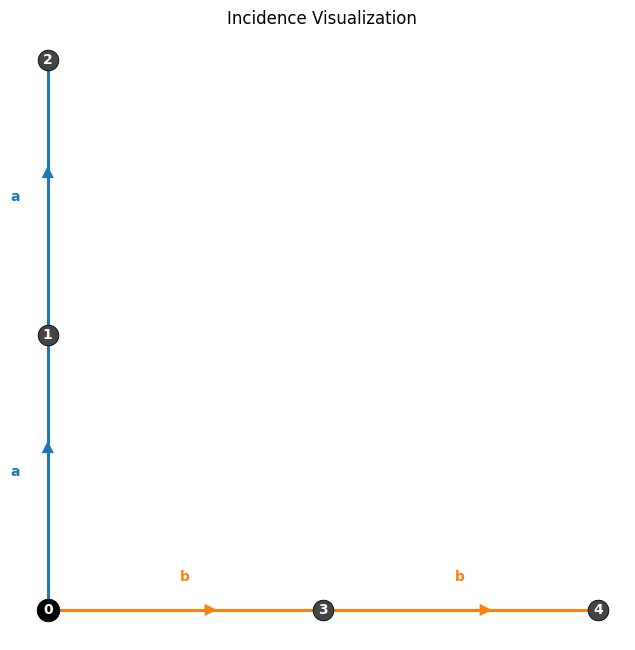


========================= Iteration 1 =========================
Points (P): 9
Lines  (L): 6

Adjacency matrix (pretty words; 0 = no edge):
         0      1      2      3      4      5      6      7      8
 0:      0      a    a⁻¹      b    b⁻¹      0      0      0      0
 1:    a⁻¹      0      a   a⁻¹b a⁻¹b⁻¹   b⁻¹a     ba      0      0
 2:      a    a⁻¹      0     ab   ab⁻¹      0      0 b⁻¹a⁻¹   ba⁻¹
 3:    b⁻¹   b⁻¹a b⁻¹a⁻¹      0      b   a⁻¹b      0     ab      0
 4:      b     ba   ba⁻¹    b⁻¹      0      0 a⁻¹b⁻¹      0   ab⁻¹
 5:      0   a⁻¹b      0   b⁻¹a      0      0      0      0      0
 6:      0 a⁻¹b⁻¹      0      0     ba      0      0      0      0
 7:      0      0     ab b⁻¹a⁻¹      0      0      0      0      0
 8:      0      0   ab⁻¹      0   ba⁻¹      0      0      0      0

WORDS (in insertion order): ['a', 'b', 'a⁻¹b', 'a⁻¹b⁻¹', 'ab', 'ab⁻¹']

LINES (word: [point_ids]):
  a: [0, 1, 2]
  b: [0, 3, 4]
  a⁻¹b: [1, 3, 5]
  a⁻¹b⁻¹: [1, 4, 6]
  ab: [2, 3, 7]
  ab⁻¹

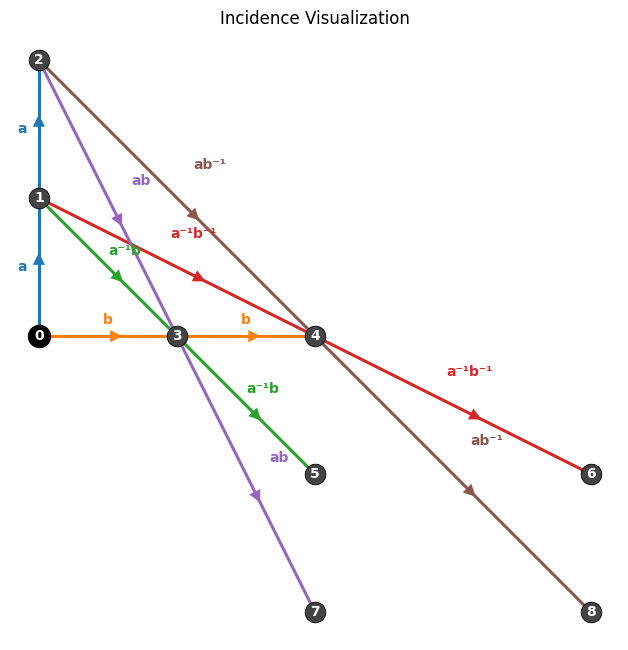


========================= Iteration 2 =========================
Points (P): 27
Lines  (L): 24

Adjacency matrix (pretty words; 0 = no edge):
                0             1             2             3             4             5             6             7             8             9            10            11            12            13            14            15            16            17            18            19            20            21            22            23            24            25            26
 0:             0             a           a⁻¹             b           b⁻¹         ab⁻¹a           aba     a⁻¹b⁻¹a⁻¹       a⁻¹ba⁻¹       a⁻¹ba⁻¹     a⁻¹b⁻¹a⁻¹           aba         ab⁻¹a             0             0             0             0             0             0             0             0             0             0             0             0             0             0
 1:           a⁻¹             0             a          a⁻¹b        a⁻¹b⁻¹          b⁻¹a       

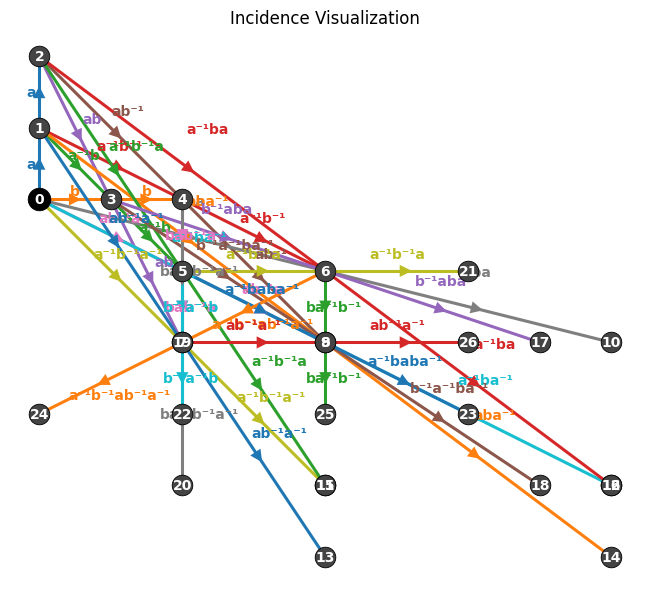


========================= Iteration 3 =========================
Points (P): 306
Lines  (L): 303

Adjacency matrix (pretty words; 0 = no edge):
                               0                            1                            2                            3                            4                            5                            6                            7                            8                            9                           10                           11                           12                           13                           14                           15                           16                           17                           18                           19                           20                           21                           22                           23                           24                           25                           26                           27                           28            

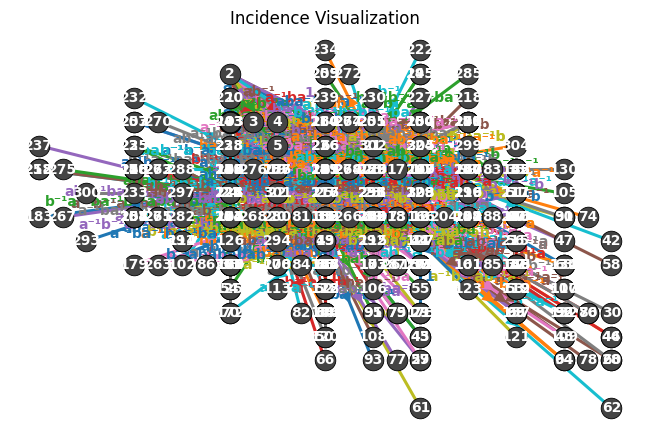

In [2]:
# =========================
# Example usage
# =========================

if __name__ == "__main__":
    # Example: cardinality (order) = 3, rank = 2, and show the first 3 iterations.
    c, r, iterations = 3, 2, 3
    build_and_iterate(c, r, iterations)

### Example 2

*   Cardinality (Order): 5
*   Rank: 2
*   Number of Iterations: 1



========================= Iteration 0 (initial) =========================
Points (P): 9
Lines  (L): 2

Adjacency matrix (pretty words; 0 = no edge):
      0   1   2   3   4   5   6   7   8
 0:   0   a   0   0 a⁻¹   b   0   0 b⁻¹
 1: a⁻¹   0   a   0   0   0   0   0   0
 2:   0 a⁻¹   0   a   0   0   0   0   0
 3:   0   0 a⁻¹   0   a   0   0   0   0
 4:   a   0   0 a⁻¹   0   0   0   0   0
 5: b⁻¹   0   0   0   0   0   b   0   0
 6:   0   0   0   0   0 b⁻¹   0   b   0
 7:   0   0   0   0   0   0 b⁻¹   0   b
 8:   b   0   0   0   0   0   0 b⁻¹   0

WORDS (in insertion order): ['a', 'b']

LINES (word: [point_ids]):
  a: [0, 1, 2, 3, 4]
  b: [0, 5, 6, 7, 8]


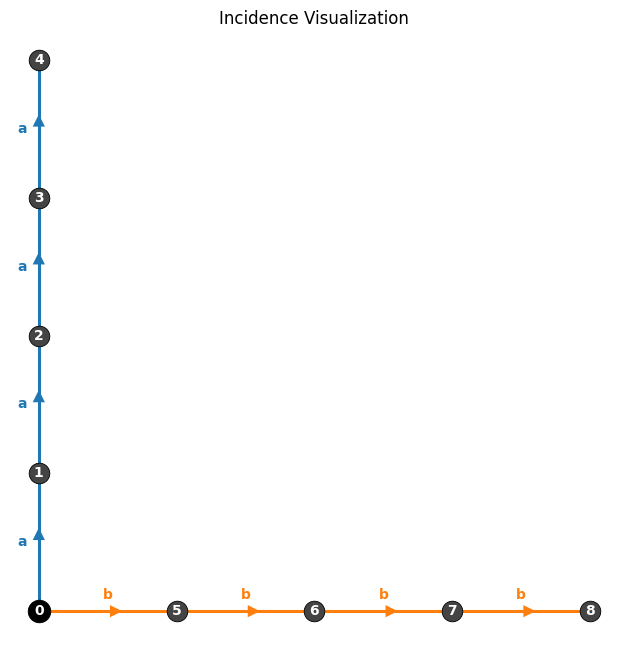


========================= Iteration 1 =========================
Points (P): 57
Lines  (L): 18

Adjacency matrix (pretty words; 0 = no edge):
         0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38     39     40     41     42     43     44     45     46     47     48     49     50     51     52     53     54     55     56
 0:      0      a      0      0    a⁻¹      b      0      0    b⁻¹      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0
 1:    a⁻¹      0      a      0      0   a⁻¹b  a⁻¹b²

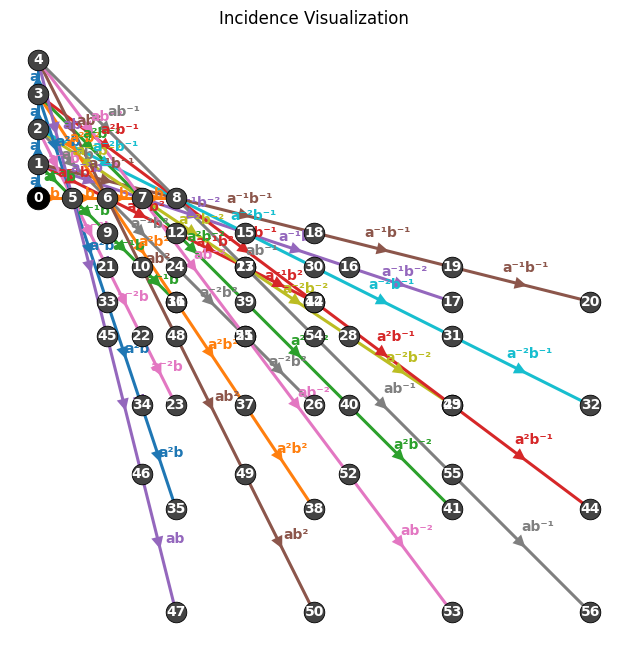

In [3]:
# =========================
# Example usage
# =========================

if __name__ == "__main__":
    # Example: cardinality (order) = 5, rank = 2, and show the first 1 iteration.
    c, r, iterations = 5, 2, 1
    build_and_iterate(c, r, iterations)

### Example 3

*   Cardinality (Order): 4
*   Rank: 3
*   Number of Iterations: 1


========================= Iteration 0 (initial) =========================
Points (P): 10
Lines  (L): 3

Adjacency matrix (pretty words; 0 = no edge):
      0   1   2   3   4   5   6   7   8   9
 0:   0   a   0 a⁻¹   b   0 b⁻¹   c   0 c⁻¹
 1: a⁻¹   0   a   0   0   0   0   0   0   0
 2:   0 a⁻¹   0   a   0   0   0   0   0   0
 3:   a   0 a⁻¹   0   0   0   0   0   0   0
 4: b⁻¹   0   0   0   0   b   0   0   0   0
 5:   0   0   0   0 b⁻¹   0   b   0   0   0
 6:   b   0   0   0   0 b⁻¹   0   0   0   0
 7: c⁻¹   0   0   0   0   0   0   0   c   0
 8:   0   0   0   0   0   0   0 c⁻¹   0   c
 9:   c   0   0   0   0   0   0   0 c⁻¹   0

WORDS (in insertion order): ['a', 'b', 'c']

LINES (word: [point_ids]):
  a: [0, 1, 2, 3]
  b: [0, 4, 5, 6]
  c: [0, 7, 8, 9]


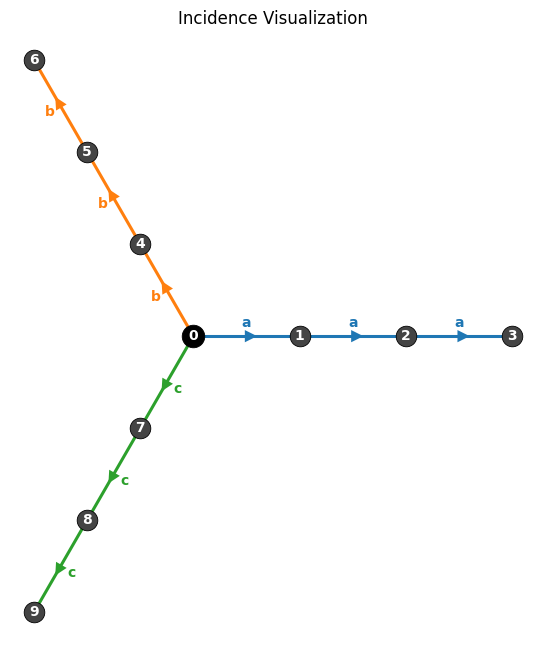


========================= Iteration 1 =========================
Points (P): 64
Lines  (L): 30

Adjacency matrix (pretty words; 0 = no edge):
         0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38     39     40     41     42     43     44     45     46     47     48     49     50     51     52     53     54     55     56     57     58     59     60     61     62     63
 0:      0      a      0    a⁻¹      b      0    b⁻¹      c      0    c⁻¹      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0    

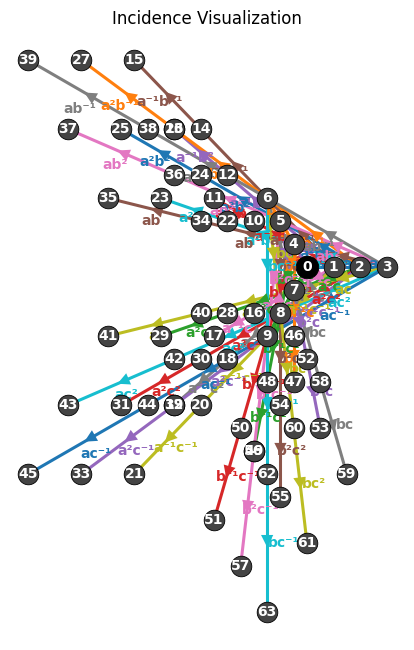

In [4]:
# =========================
# Example usage
# =========================

if __name__ == "__main__":
    # Example: cardinality (order) = 4, rank = 3, and show the first 1 iteration.
    c, r, iterations = 4, 3, 1
    build_and_iterate(c, r, iterations)

### Example 4

*   Cardinality (Order): 2
*   Rank: 2
*   Number of Iterations: 4


========================= Iteration 0 (initial) =========================
Points (P): 3
Lines  (L): 2

Adjacency matrix (pretty words; 0 = no edge):
     0  1  2
 0:  0  a  b
 1:  a  0  0
 2:  b  0  0

WORDS (in insertion order): ['a', 'b']

LINES (word: [point_ids]):
  a: [0, 1]
  b: [0, 2]


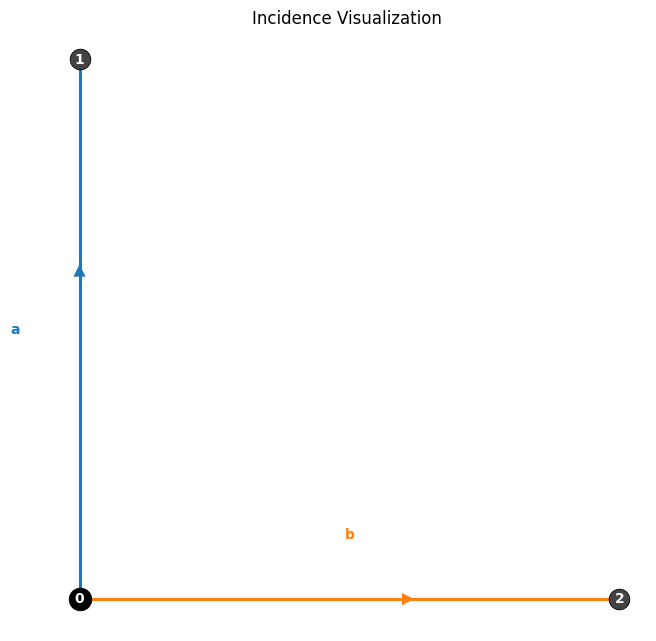


========================= Iteration 1 =========================
Points (P): 3
Lines  (L): 3

Adjacency matrix (pretty words; 0 = no edge):
     0  1  2
 0:  0  a  b
 1:  a  0 ab
 2:  b ba  0

WORDS (in insertion order): ['a', 'b', 'ab']

LINES (word: [point_ids]):
  a: [0, 1]
  b: [0, 2]
  ab: [1, 2]


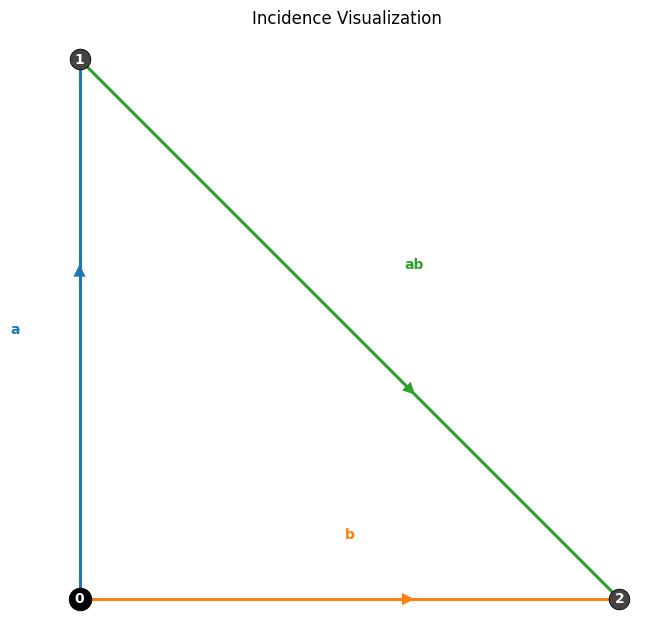


========================= Iteration 2 =========================
Points (P): 3
Lines  (L): 3

Adjacency matrix (pretty words; 0 = no edge):
     0  1  2
 0:  0  a  b
 1:  a  0 ab
 2:  b ba  0

WORDS (in insertion order): ['a', 'b', 'ab']

LINES (word: [point_ids]):
  a: [0, 1]
  b: [0, 2]
  ab: [1, 2]


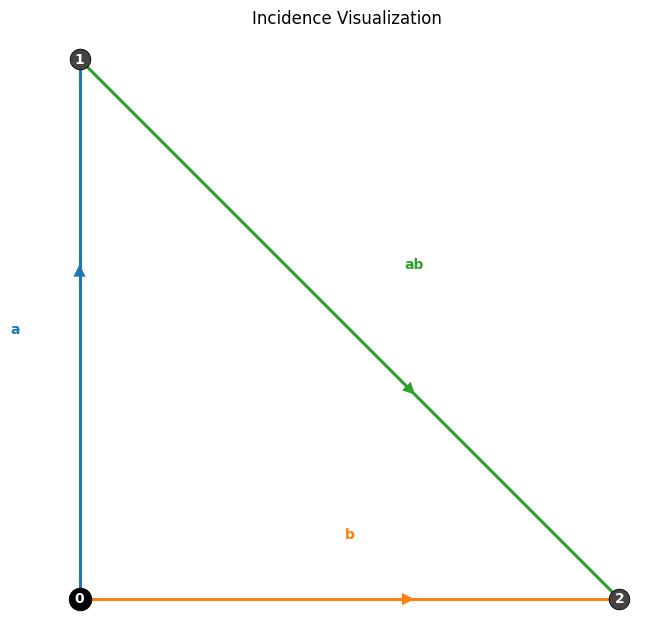


========================= Iteration 3 =========================
Points (P): 3
Lines  (L): 3

Adjacency matrix (pretty words; 0 = no edge):
     0  1  2
 0:  0  a  b
 1:  a  0 ab
 2:  b ba  0

WORDS (in insertion order): ['a', 'b', 'ab']

LINES (word: [point_ids]):
  a: [0, 1]
  b: [0, 2]
  ab: [1, 2]


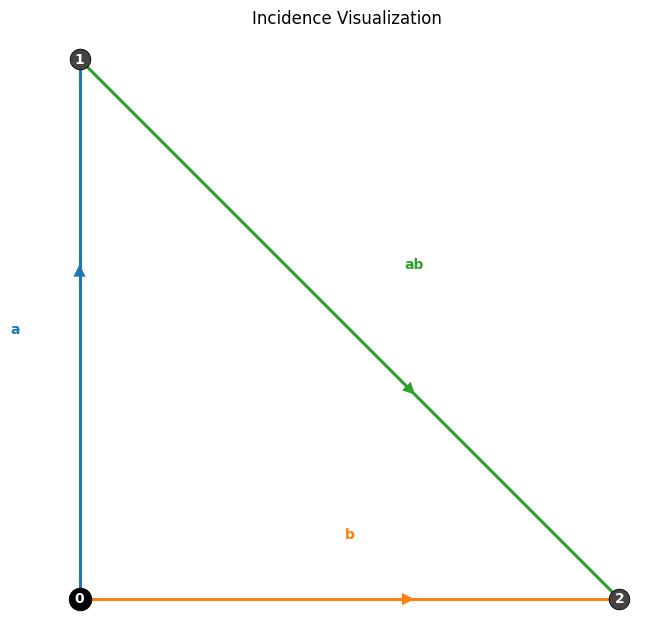


========================= Iteration 4 =========================
Points (P): 3
Lines  (L): 3

Adjacency matrix (pretty words; 0 = no edge):
     0  1  2
 0:  0  a  b
 1:  a  0 ab
 2:  b ba  0

WORDS (in insertion order): ['a', 'b', 'ab']

LINES (word: [point_ids]):
  a: [0, 1]
  b: [0, 2]
  ab: [1, 2]


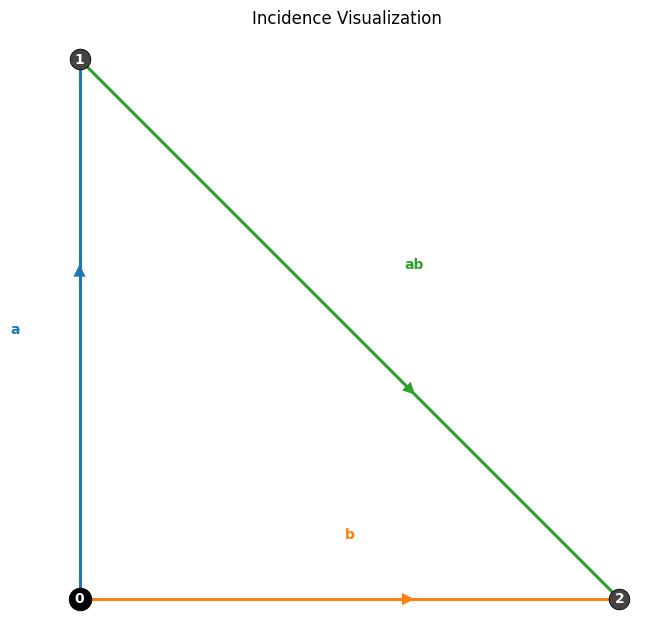

In [5]:
# =========================
# Example usage
# =========================

if __name__ == "__main__":
    # Example: cardinality (order) = 2, rank = 2, and show the first 4 iterations.
    c, r, iterations = 2, 2, 4
    build_and_iterate(c, r, iterations)